In [1]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf 
# from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


/Users/amolgaikwad/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from tensorflow.keras.utils import to_categorical


In [4]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

In [5]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

Open a real image

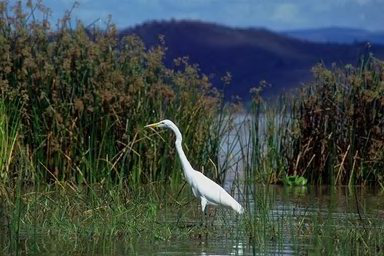

In [6]:
real_image_path = 'C:/Users/IT Support/Downloads/nuke/real and fake image processing/CASIA2/Au/Au_ani_00002.jpg'
Image.open(real_image_path)


After converting to ELA image

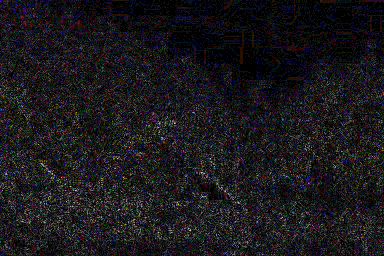

In [7]:
convert_to_ela_image(real_image_path, 90)

Open a fake image

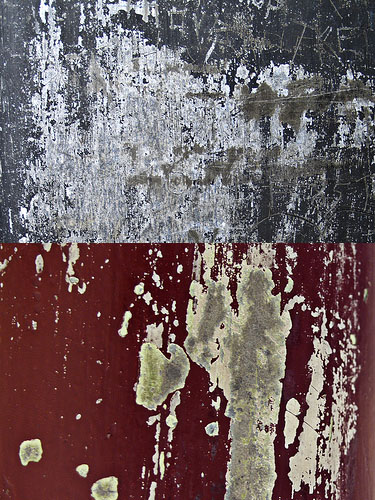

In [8]:
fake_image_path = 'CASIA2/Tp/Tp_D_CNN_M_N_txt10109_txt10110_10816.jpg'
Image.open(fake_image_path)

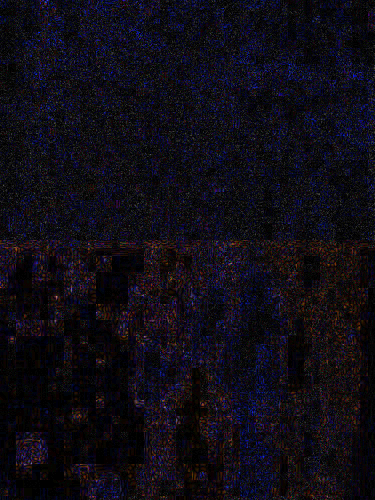

In [9]:
convert_to_ela_image(fake_image_path, 90)

Dataset Preparation

In [10]:
image_size = (200, 200)

In [11]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [12]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

Au => Total Images 7354, Take 2100 random images from the list
Tp => Total Images 2064

In [13]:
import random
path = 'C:/Users/IT Support/Downloads/nuke/real and fake image processing/CASIA2/Au/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:2100]
Y = Y[:2100]
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
2100 2100


In [14]:
path = 'C:/Users/IT Support/Downloads/nuke/real and fake image processing/CASIA2/Tp/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
4164 4164


In [15]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 200, 200, 3)

Train Test split with 80:20 ratio

In [16]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

3331 3331
833 833


CNN Model

In [17]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (200, 200, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (200, 200, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

In [18]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 196, 196, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 96, 96, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 96, 96, 32)        0         
                                                                 
 flatten (Flatten)           (None, 294912)            0         
                                                                 
 dense (Dense)               (None, 256)               75497728  
                                                        

In [19]:
epochs = 10
batch_size = 10


In [20]:
init_lr = 1e-4
optimizer = tf.keras.optimizers.legacy.Adam(lr = init_lr, decay = init_lr/epochs)

c:\Users\IT Support\anaconda3\lib\site-packages\keras\src\optimizers\legacy\adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [21]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [22]:
early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')

In [23]:



history = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/10
334/334 [==============================] - 217s 648ms/step - loss: 0.4231 - accuracy: 0.8160 - val_loss: 0.2781 - val_accuracy: 0.8992
Epoch 2/10
334/334 [==============================] - 224s 670ms/step - loss: 0.2777 - accuracy: 0.9030 - val_loss: 0.2239 - val_accuracy: 0.9172
Epoch 3/10
334/334 [==============================] - 219s 657ms/step - loss: 0.1947 - accuracy: 0.9355 - val_loss: 0.1888 - val_accuracy: 0.9256
Epoch 4/10
334/334 [==============================] - 221s 662ms/step - loss: 0.1465 - accuracy: 0.9454 - val_loss: 0.1835 - val_accuracy: 0.9268
Epoch 5/10
334/334 [==============================] - 219s 656ms/step - loss: 0.1185 - accuracy: 0.9586 - val_loss: 0.1823 - val_accuracy: 0.9292
Epoch 6/10
334/334 [==============================] - 219s 656ms/step - loss: 0.0909 - accuracy: 0.9643 - val_loss: 0.2166 - val_accuracy: 0.9328
Epoch 7/10
334/334 [==============================] - 218s 652ms/step - loss: 0.0801 - accuracy: 0.9715 - val_loss: 0.1846 -

In [24]:
model.save('casia.h5')

c:\Users\IT Support\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

27/27 [==============================] - 8s 275ms/step


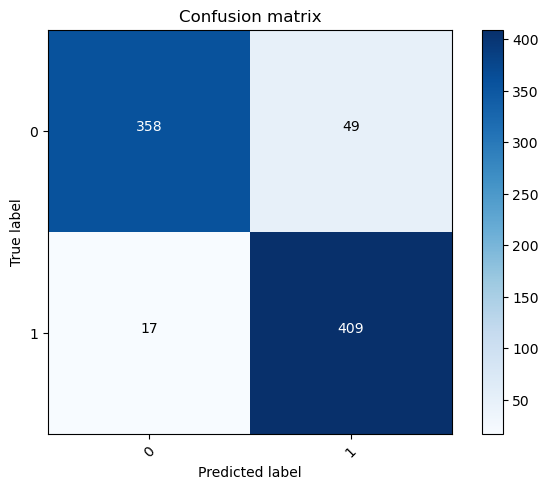

In [26]:

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [28]:
from sklearn.metrics import accuracy_score
acc=accuracy_score(Y_true,Y_pred_classes) 
print('Accuracy: %.3f' % acc)
from sklearn.metrics import precision_score
precision = precision_score(Y_true,Y_pred_classes,labels=[1,2], average='micro')
print('Precision: %.3f' % precision)
from sklearn.metrics import recall_score
recall = recall_score(Y_true,Y_pred_classes, average='micro')
print('Recall: %.3f' % recall)
from sklearn.metrics import f1_score
score = f1_score(Y_true,Y_pred_classes, average='micro')
print('F-Measure: %.3f' % score)

Accuracy: 0.921
Precision: 0.893
Recall: 0.921
F-Measure: 0.921


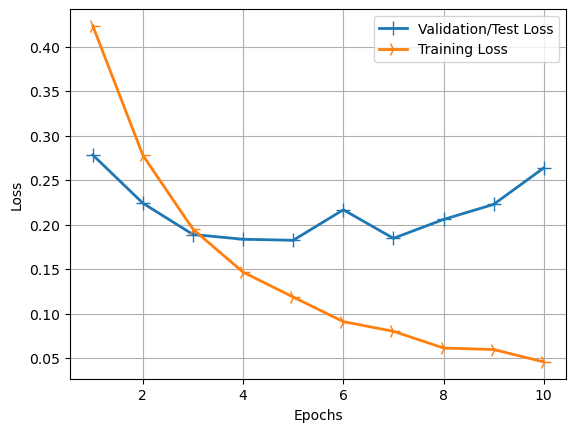

In [31]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

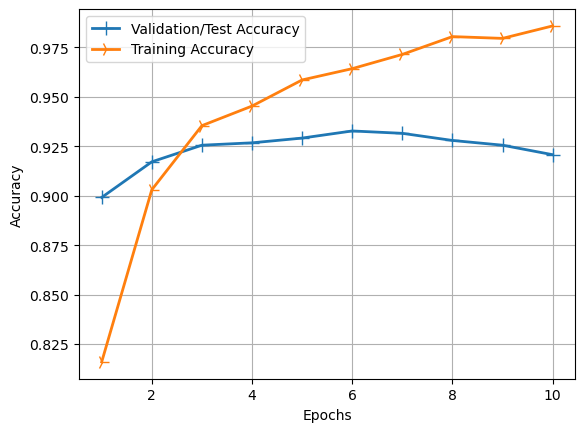

In [37]:
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [33]:

class_names = {
0: 'fake',
1: 'real',

}

In [34]:
real_image_path = 'C:/Users/IT Support/Downloads/nuke/real and fake image processing/CASIA2/Au/Au_ani_00001.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 200, 200, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]

print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 81ms/step
Class: real Confidence: 100.00


In [35]:
real_image_path = 'C:/Users/IT Support/Downloads/nuke/real and fake image processing/CASIA2/Tp/Tp_D_CND_S_N_txt00028_txt00006_10848.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 200, 200, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]

print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 65ms/step
Class: fake Confidence: 99.99
